# Simulating Focus Tracking

Below we simulate focus tracking behaviour with a simple implementation that takes errors in determining z, dz and actual piezo movements into account. We show that the original implementation gives rise to inherent instabilities that drifts away from the desired position in the presence of any non-negligible errors.

We also demonstrate some fixes, including a prescribed stabilized focus time course such as in a z series.

### Matplotlib preparation

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

### Importing our simulation modules and making the basic objects

In [2]:
import TrackerSim as Tracker
import sampleTimeCourse as STC
import opsim
bp = opsim.rawpiezoSimNoisy(readerr=5.0,moverr=10.0)
op = opsim.piezoOffsetSim(bp)

sampletc = STC.sampleTC(10000,amp=100,period=2000)
cmdtc = STC.sampleTC(10000,amp=100,period=2500,mode='sawtooth') # a sawtooth shaped command focus time course

### Basic Tracking Simulation Results

The implementation is based on a Tracker class.

```python
class Tracker(object):
    def __init__(self,offsetpiezo,sampleTimeCourse,dzerr=0.0):
        self.piezo = offsetpiezo
        self.stc = sampleTimeCourse
        self.dzerr=dzerr
        self.history = []
```

The meat is in the compare method which determines the dz to move through to keep the focus stable and the track method which carries out the tracking by iteratively calling compare and adjusting the offset piezo if the deviation exceeds a specified threshold.

In the actual comapre method in experiments we determine the raw dz by correlation. Here we use the idea that the sample follows a prescribed time course (stored in self.stc) in absolute space and the objective is focused at a position we obtain with self.piezo.focus. This is taken to be simply the actual position of the basepiezo, in reality it would be the piezo position plus some fixed distance reflecting the objective but we avoid that by chosing our coordinate origin so that this distance is zero (which we can always do without loss of generality). 

To mimic the current PYME code we allow the use of the posDelta idea, presumably adopted by David so that, for example, z-series can change the nominal position of the offset piezo while still tracking the focus properly. This can be switched by optional arguments to the track method, as can be how the posDelta difference is used to correct the raw dz. We believe it should be subtracted rather than added and a second switch to the track method allows doing that.

```python
    def compare(self,tick):
        samplez = self.stc.z(tick)
        focus = self.piezo.focus()

        posDelta = self.piezo.GetPos(0) - self.calibpos
        dz = focus - samplez + gausserr(self.dzerr)
        if self.useposDelta:
            if self.addDelta:
                return dz + posDelta
            else:
                return dz - posDelta
        else:
            return dz

    def track(self,tolerance,minDelay=5, useposDelta=False, addDelta=True):
        self.minDelay = minDelay
        self.focusTolerance = tolerance
        self.useposDelta = useposDelta
        self.addDelta = addDelta

        self.opInit(self.stc.z(0))
        for tick in range(self.stc.ntics):
            t = self.stc.t(tick)
            dz = self.compare(tick)
            self.history.append((t, dz, self.piezo.GetOffset(), self.piezo.GetPos(0),
                                 self.stc.z(tick), self.piezo.focus()))
            if abs(dz) > self.focusTolerance and self.lastAdjustment >= self.minDelay:
                zcorr = self.piezo.GetOffset() - dz
                self.piezo.SetOffset(zcorr)
                self.lastAdjustment = 0
            else:
                self.lastAdjustment += 1
```

The main issue that we found is that the implementation of the posDelta approach is unstable against errors in determining z, raw dz and errors in moving the sample according to the corrected dz (Note: we need to check again which errors are more problematic and which seem to matter less or not at all).

The issue appears to be that errors feed into the nominal position of the offset piezo (the one returned by self.piezo.getPos()) as all corrections are fed into the offset. This means that the nominal position of the offset piezo apparently drifts, but in actuality the true focus does not drift, it is just that the errors lead to a redistribution between nominal position and offset.

This leads to a problem as the assumption is that the nominal position stays constant in proper tracking (within the chosen threshold) and the calculation of posDelta uses that assumption, see the effect below.

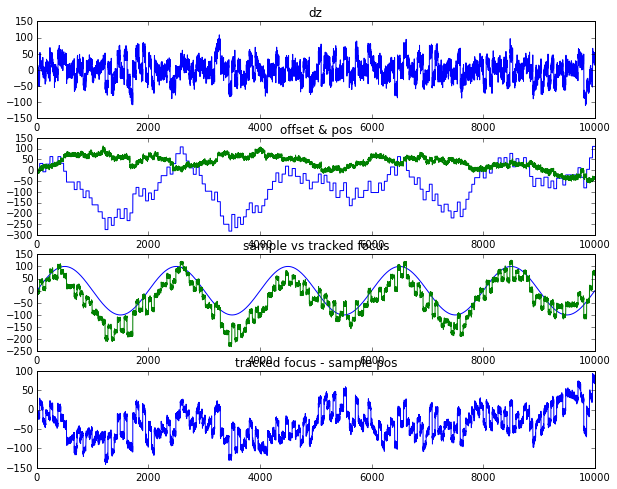

In [3]:
tr2 = Tracker.Tracker(op,sampletc,dzerr=10.0)
tr2.track(tolerance=30,minDelay=50,useposDelta=True)
tr2.plothistory()

#### Ignoring posDelta fixes the instability

The simple fix is to avoid using the posDelta correction to the raw dz and base all corrections on the raw dz. This seems to make the procedure stable but loses the ability to prescribe a command waveform, rather it holds the focus fixed at wherever tracking was started. We tackle this further below in another modification.

For now, ignoring posDelta should be good enough.

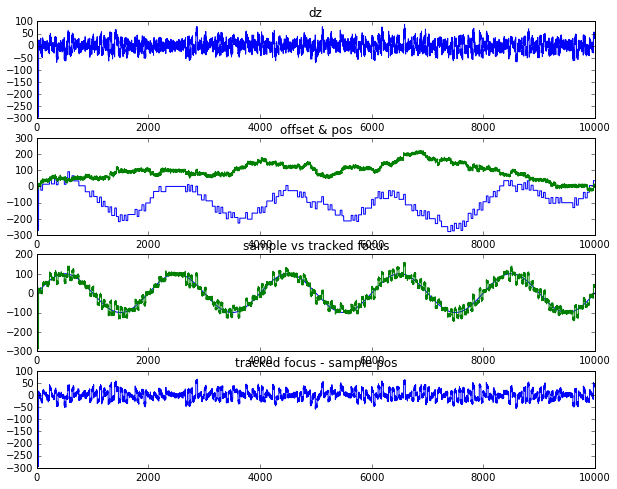

In [5]:
tr2 = Tracker.Tracker(op,sampletc,dzerr=10.0)
tr2.track(tolerance=30,minDelay=30,useposDelta=False)
tr2.plothistory()

### Tracking focus but using a prescribed command time course

A variation of the simple tracker modelled on the current PYME code uses a prescribed command time course. The implementation is modtly inherited from the basic Tracker class. It takes an additional cmdTimeCourse argument which gives z as a function of time and is interpreted with respect to the calibrated position (? need to check the semantics of that).

```python
class TrackerCmdTC(Tracker):
    def __init__(self,offsetpiezo,sampleTimeCourse, cmdTimeCourse, dzerr=0.0):
        self.cmdTC = cmdTimeCourse
        super(self.__class__, self).__init__(offsetpiezo,sampleTimeCourse,dzerr)
```

The guts is in the compare method which computes a posDelta which is subtracted from the determined dz:
```python
    def compare(self,tick):
        samplez = self.stc.z(tick)
        focus = self.piezo.focus()

        posDelta = self.cmdTC.z(tick) - self.calibpos
        dz = focus - samplez
        return dz - posDelta + gausserr(self.dzerr)
```
A tricky bit for implementing this with our experimental offsetpiezo approach is that the command time course is interpreted relative to the original calibration position, so there could be issues in our current z-sieries implementation as it manipulates the nominal offsetpiezo position rather than giving a special command to interpret the z movement relative to the orginal calibration position. This may need code changes but here we just demonstrate the principle.

In principle at least this modification seems to do the trick as shown below.

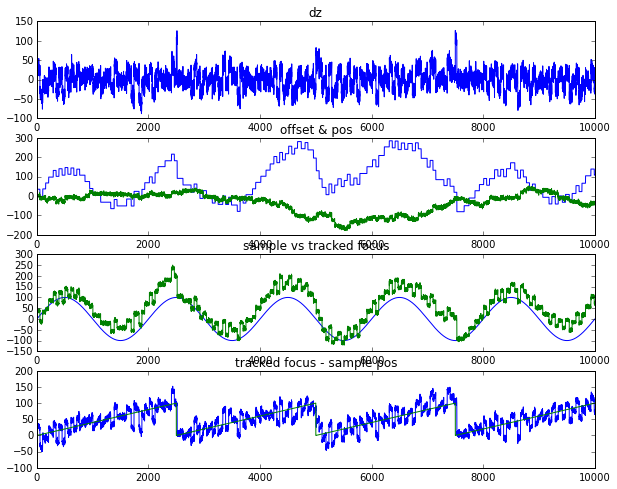

In [6]:
tr = Tracker.TrackerCmdTC(op,sampletc,cmdtc,dzerr=10.0)
tr.track(tolerance=30,minDelay=50)
t, dz, poffset, pos, samplez, focus  = np.array(tr.history).T
tr.plothistory()

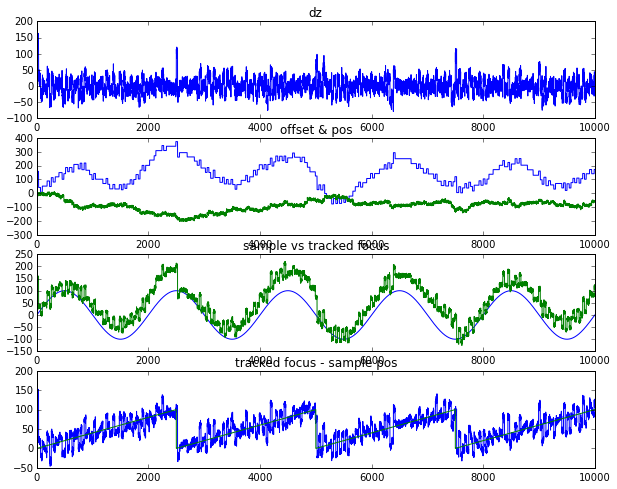

In [8]:
tr.track(tolerance=30,minDelay=30)
tr.plothistory()